In [118]:
import statistics
from collections import defaultdict
from tqdm.notebook import tqdm

import pyro
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(7)
pyro.set_rng_seed(0)
np.random.seed(19680801)

from pyro.infer import SVI, Trace_ELBO, Importance, EmpiricalMarginal
import torch.distributions.constraints as constraints
from pyro.optim import Adam

# Constants
MAX_ABUNDANCE = 100

In [47]:
# load data
data_path = "../Tests/Data/mapk3000.csv"

data = pd.read_csv(data_path)
num_samples = data.shape[0]

single_interaction_data = data[["a(p(Mek))","a(p(Erk))"]]

parent = single_interaction_data["a(p(Mek))"].to_numpy()
target = single_interaction_data["a(p(Erk))"].to_numpy()

In [48]:
# Log transformation
def transform_target_to_log(target):
    return np.log(target / (MAX_ABUNDANCE - target))

def transform_parent_to_log(parent):
    return np.log(parent)

target_transformed_to_log = transform_target_to_log(target)


parent_transformed_to_log = transform_parent_to_log(parent)
Features = np.vstack([parent_transformed_to_log, np.ones(len(parent_transformed_to_log))]).T


In [49]:
print(target[:2])
print(target_transformed_to_log[:2])
print(parent_transformed_to_log[:2])

[82 91]
[1.51634749 2.31363493]
[4.02535169 4.31748811]


In [50]:
# Linear Regression - get slope and intercept
m, c = np.linalg.lstsq(Features, target_transformed_to_log, rcond=None)[0]

# Define n and k
n = m
# c = -n log k, then k = exp(-c/n)
k = np.exp(-c/n)

In [51]:
# Hill equation
def hill(x, k, n):
    return MAX_ABUNDANCE/ (1 + np.power((x / k), -n))

predicted_target = hill(parent, k, n)
print(predicted_target[:6])
print(target[:6])

[83.58967083 86.41242075 83.40100856 84.46168461 85.65125851 81.91922869]
[82 91 79 87 86 81]


In [52]:
k, n

(6.571100121905458, 0.7598037354277741)

In [53]:
# Report mean squared error

mse = np.square(np.subtract(target, predicted_target)).mean()

print("Mean squared error on train:", mse)

Mean squared error on train: 13.265515618622066


### Regression line in log space

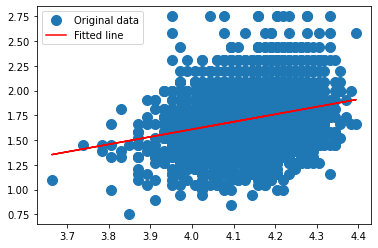

In [54]:
_ = plt.plot(parent_transformed_to_log, target_transformed_to_log, 'o', label='Original data', markersize=10)
_ = plt.plot(parent_transformed_to_log, m*parent_transformed_to_log + c, 'r', label='Fitted line')
_ = plt.legend()
plt.show()

### Regression line in actual space 

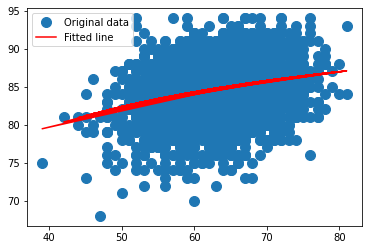

In [55]:
_ = plt.plot(parent, target, 'o', label='Original data', markersize=10)
_ = plt.plot(parent, predicted_target, 'r', label='Fitted line')
_ = plt.legend()
plt.show()

### get residual and parent statistics

In [56]:
residual_std = np.abs(np.subtract(target, predicted_target)).std()
print(residual_std)

parent_mean = parent.mean()
parent_std = parent.std()

2.2132951046150495


### Define Pyro model

In [76]:
# Hill with noise
def hill_with_residual_noise(x, k, n, noise):
    return MAX_ABUNDANCE/ (1 + np.power(((x / k) + noise), -n))

# pyro model
def model(n_erk):
    noise = pyro.sample("n_Erk", n_erk)
    mek = pyro.sample("Mek", pyro.distributions.Normal(parent_mean, parent_std))
    
    erk_mean = hill_with_residual_noise(mek.detach().numpy(), k, n, noise.detach().numpy())
    erk = pyro.sample("Erk", pyro.distributions.Normal(erk_mean, 1.0))
    
    return mek,erk

In [77]:
n_erk = pyro.distributions.Normal(0.0, torch.tensor(residual_std))
samples = torch.tensor([model(n_erk) for _ in range(3000)])

In [78]:
print(samples[:10,1])
print(target[:10])

tensor([85.5415, 82.6491, 86.2939, 82.8984, 82.2052, 87.3095, 85.5161, 84.5994,
        81.7752, 76.0414])
[82 91 79 87 86 81 85 81 82 81]


### Generated samples Vs. Original Data

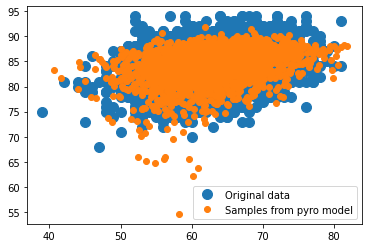

In [60]:
_ = plt.plot(parent, target, 'o', label='Original data', markersize=10)
_ = plt.plot(samples[:,0], samples[:,1], 'o', label='Samples from pyro model')
_ = plt.legend()
plt.show()

### Counterfactual inference

In [108]:
def infer_using_svi(conditioned_model, n_erk):

    def guide(n_erk):
        mu_constraints = constraints.interval(0., 5.)
        sigma_constraints = constraints.interval(.1, 7.)
        mu_guide = pyro.param("mu_n_Erk", torch.tensor(0.0), constraint=mu_constraints)
        sigma_guide = pyro.param("sigma_n_Erk", torch.tensor(residual_std),
                                     constraint=sigma_constraints)
        pyro.sample("n_Erk", pyro.distributions.Normal(mu_guide, sigma_guide))

    pyro.clear_param_store()

    svi = SVI(
        model=conditioned_model,
        guide=guide,
        optim=Adam({"lr": 0.0005, "betas": (0.95, 0.999)}),
        loss=Trace_ELBO(retain_graph=True)
    )
    losses = []
    num_steps = 1000
    samples = defaultdict(list)
    for t in tqdm(range(num_steps)):
        loss = svi.step(n_erk)
        #print(t, loss)
        losses.append(loss)
        mu = 'mu_n_Erk'
        sigma = 'sigma_n_Erk'
        samples[mu].append(pyro.param(mu).item())
        samples[sigma].append(pyro.param(sigma).item())
    means = {k: statistics.mean(v) for k, v in samples.items()}

    updated_noise = {}
    updated_noise = pyro.distributions.Normal(means["mu_n_Erk"], means["sigma_n_Erk"])

    return updated_noise, losses

In [113]:
def counterfactual_inference(intervened_mek):
    n_erk = pyro.distributions.Normal(0.0, torch.tensor(residual_std))

    # Generate a sample
    observed_mek, observed_erk = model(n_erk)

    print("Observed Mek:", observed_mek, "Observed Erk:", observed_erk)
    print("What would happen to Erk if Mek was", intervened_mek, "?")
    conditioned_model = pyro.condition(model, data={"Mek": observed_mek, "Erk": observed_erk})
    updated_n_erk = infer_using_svi(conditioned_model, n_erk)

    intervention_model = pyro.do(model, data={"Mek":torch.tensor(intervened_mek)})
    return intervention_model, updated_n_erk[0]

In [121]:
intervened_model_1, noise_1 = counterfactual_inference(60.)
intervened_model_2, noise_2 = counterfactual_inference(80.)

counterfactual_erk_1 = torch.tensor([intervened_model_1(noise_1)[1] for _ in range(1000)])
counterfactual_erk_2 = torch.tensor([intervened_model_2(noise_2)[1] for _ in range(1000)])

Observed Mek: tensor(60.2357) Observed Erk: tensor(81.1811)
What would happen to Erk if Mek was 60.0 ?



Observed Mek: tensor(61.3546) Observed Erk: tensor(88.1486)
What would happen to Erk if Mek was 80.0 ?


In [122]:
noise_1, noise_2

(Normal(loc: 5.877471754111438e-38, scale: 2.226332426071167),
 Normal(loc: 5.877471754111438e-38, scale: 2.1990931034088135))

In [123]:
print(counterfactual_erk_1[:10])
print(counterfactual_erk_2[:10])

tensor([85.1489, 75.5679, 83.9824, 85.5736, 84.1857, 86.8123, 87.1574, 82.3624,
        86.5266, 86.3167])
tensor([85.7890, 84.5812, 85.2482, 85.0651, 85.8262, 86.1482, 85.5899, 88.3439,
        84.9131, 87.1870])


In [126]:
print("Counterfactual Erk when Mek = 60:: Mean", counterfactual_erk_1.mean(), counterfactual_erk_1.std())
print("Counterfactual Erk when Mek = 80:: Mean", counterfactual_erk_2.mean(), counterfactual_erk_2.std())

Counterfactual Erk when Mek = 60:: Mean tensor(83.7009) tensor(3.1846)
Counterfactual Erk when Mek = 80:: Mean tensor(86.6406) tensor(2.0625)


### Open items:

* Working example of counterfactual inference on this two node SCM. - Done.
* Hill equation formulation with activators and inhibitors combined.